# 

In [2]:
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 89.4 MB/s eta 0:00:00:00:0100:01


In [3]:
!pip uninstall -y datasets

# Install the latest stable version of datasets
!pip install --upgrade datasets

Found existing installation: datasets 3.6.0
Uninstalling datasets-3.6.0:
  Successfully uninstalled datasets-3.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 

In [4]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
# for lang, dataset in mydatasets.items():
#         # Create language directory
        
#         print(f"Saving {lang} samples...")
#         for i, item in enumerate(dataset):
#             # Get the audio data
#             audio_array = np.array(item['audio']['array'])
#             sampling_rate = item['audio']['sampling_rate']
#             audio_tensor = torch.tensor(audio_array).unsqueeze(0)
#             print(audio_tensor)
#             break

In [6]:

from datasets import Dataset, load_dataset
import os
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
import librosa
import numpy as np
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification,Wav2Vec2Config,TrainingArguments,Trainer
import wandb
import random
import math
import json
def download_common_voice_subset(languages, num_samples=None, split="train"):
    """
    Download a subset of Common Voice for specified languages.
    
    Args:
        languages: List of language codes
        num_samples: Number of samples per language
        split: Dataset split ('train', 'test', 'validation')
    
    Returns:
        Dictionary with datasets for each language
    """
    mydatasets = {}
    
    
    for lang in languages:
        print(f"Loading {lang} dataset...")
        # Load only the specified split to save memory
        dataset = load_dataset("google/fleurs", lang, split=split,trust_remote_code=True)  # ~175MB
        
        
        # Take only a subset
        subset = dataset.select(range(min(num_samples, len(dataset))))
        mydatasets[lang] = subset
        
        print(f"Downloaded {len(subset)} samples for {lang}")
        
    return mydatasets

def save_dataset_locally(mydatasets, output_dir="./language_samples"):
    """Save audio files and metadata locally"""
    os.makedirs(output_dir, exist_ok=True)
    
    metadata = []
    
    for lang, dataset in mydatasets.items():
        # Create language directory
        lang_dir = os.path.join(output_dir, lang)
        os.makedirs(lang_dir, exist_ok=True)
        
        print(f"Saving {lang} samples...")
        for i, item in enumerate(dataset):
            # Get the audio data
            audio_array = np.array(item['audio']['array'])
            sampling_rate = item['audio']['sampling_rate']
            audio_tensor = torch.tensor(audio_array).unsqueeze(0)
            # Create a unique filename
            filename = f"{lang}_{i}.wav"
            output_path = os.path.join(lang_dir, filename)
            
            # Copy the audio file
            torchaudio.save(output_path, audio_tensor, sampling_rate)
            
            # Add to metadata
            metadata.append({
                'filename': output_path,
                'language': lang,
                'text': item['transcription']
            })
            
            if (i+1) % 10 == 0:
                print(f"Saved {i+1}/{len(dataset)} {lang} samples")
    
    # Save metadata as CSV
    df = pd.DataFrame(metadata)
    df.to_csv(os.path.join(output_dir, "metadata.csv"), index=False)
    print(f"Saved metadata to {os.path.join(output_dir, 'metadata.csv')}")
    
    return os.path.join(output_dir, "metadata.csv")



2025-05-23 01:01:20.443547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747962080.633250      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747962080.685457      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Usage
languages=["en_us","ar_eg","fr_fr"]
mydatasets = download_common_voice_subset(languages, num_samples=500)
metadata_path = save_dataset_locally(mydatasets)

Loading en_us dataset...


README.md:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

fleurs.py:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

train.tar.gz:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/171M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/290M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/213k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/368k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Downloaded 500 samples for en_us
Loading ar_eg dataset...


train.tar.gz:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/163M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/244M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/1.53M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/215k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/324k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Downloaded 500 samples for ar_eg
Loading fr_fr dataset...


train.tar.gz:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/143M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/349M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/181k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/457k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Downloaded 500 samples for fr_fr
Saving en_us samples...
Saved 10/500 en_us samples
Saved 20/500 en_us samples
Saved 30/500 en_us samples
Saved 40/500 en_us samples
Saved 50/500 en_us samples
Saved 60/500 en_us samples
Saved 70/500 en_us samples
Saved 80/500 en_us samples
Saved 90/500 en_us samples
Saved 100/500 en_us samples
Saved 110/500 en_us samples
Saved 120/500 en_us samples
Saved 130/500 en_us samples
Saved 140/500 en_us samples
Saved 150/500 en_us samples
Saved 160/500 en_us samples
Saved 170/500 en_us samples
Saved 180/500 en_us samples
Saved 190/500 en_us samples
Saved 200/500 en_us samples
Saved 210/500 en_us samples
Saved 220/500 en_us samples
Saved 230/500 en_us samples
Saved 240/500 en_us samples
Saved 250/500 en_us samples
Saved 260/500 en_us samples
Saved 270/500 en_us samples
Saved 280/500 en_us samples
Saved 290/500 en_us samples
Saved 300/500 en_us samples
Saved 310/500 en_us samples
Saved 320/500 en_us samples
Saved 330/500 en_us samples
Saved 340/500 en_us samples


In [8]:
mydatasets["ar_eg"][0]["audio"]["array"]

array([0.        , 0.        , 0.        , ..., 0.00022024, 0.00048441,
       0.0006727 ])

In [9]:
df = pd.read_csv(metadata_path, encoding='utf-8')

In [10]:
for i, row in df.iterrows():
    print(f"{row}")
    break

filename                 ./language_samples/en_us/en_us_0.wav
language                                                en_us
text        a tornado is a spinning column of very low-pre...
Name: 0, dtype: object


In [11]:
def prepare_dataset(metadata_csv):
    """Transform metadata CSV into a format ready for training"""
    
    # Load your metadata
    df = pd.read_csv(metadata_csv, encoding='utf-8')
    
    # Create mapping from language to ID
    languages = df['language'].unique()
    language_to_id = {lang: i for i, lang in enumerate(languages)}
    id_to_language = {i: lang for lang, i in language_to_id.items()}
    
    # Create dictionaries that will be used to create the dataset
    paths = []
    languages = []
    language_ids = []
    
    # Process each file
    for _, row in df.iterrows():
        try:
            # Store only the path - we'll load audio on-the-fly
            paths.append(row['filename'])
            languages.append(row['language'])
            language_ids.append(language_to_id[row['language']])
        except Exception as e:
            print(f"Error processing {row['filename']}: {e}")
    
    # Create the dataset directly
    dataset_dict = {
        'path': paths,
        'language': languages,
        'language_id': language_ids
    }
    dataset = Dataset.from_dict(dataset_dict)
    
    # Add a function to load audio when needed
    def load_audio(example):
        audio, sr = librosa.load(example['path'], sr=16000)
        
        return {'audio': np.array(audio, dtype=np.float32), 'sampling_rate': 16000}
    
    # Apply the audio loading function
    dataset = dataset.map(load_audio)
    
    return dataset, language_to_id, id_to_language

In [12]:
dataset, language_to_id, id_to_language = prepare_dataset("/kaggle/working/language_samples/metadata.csv")

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [13]:
# import numpy as np

# # Make sure you have called prepare_dataset and assigned its output:
# # dataset, language_to_id, id_to_language = prepare_dataset(metadata_path)

# # --- Start of inspection code ---

# # Check the first sample (assuming it's English based on your previous output)
# en_sample = dataset[0]

# print(f"Keys in dataset[0]: {en_sample.keys()}")

# if 'audio' in en_sample:
#     audio_data_en = en_sample['audio']
    
#     # If it's a list, convert to NumPy array. If it's already an array, this does nothing.
#     if isinstance(audio_data_en, list):
#         print("Warning: audio data for English sample is a list, converting to numpy array.")
#         audio_data_en = np.array(audio_data_en, dtype=np.float32) # Ensure correct dtype
    
#     print(f"English audio sample (index 0):")
#     print(f"Type: {type(audio_data_en)}")
#     print(f"Shape: {audio_data_en.shape}")
#     print(f"Mean: {np.mean(audio_data_en):.4f}")
#     print(f"Std: {np.std(audio_data_en):.4f}")
#     print(f"Language: {en_sample['language']}, ID: {en_sample['language_id']}")
    
#     # You can also check if it's all zeros
#     if np.all(audio_data_en == 0):
#         print("ALERT: English audio sample is all zeros!")
# else:
#     print("Error: 'audio' key not found in dataset[0]. Did map(load_audio) run correctly?")


# # Check an Arabic sample
# # Find an Arabic sample safely, as order might vary
# ar_sample_index = -1
# for i, ex in enumerate(dataset):
#     if ex['language'] == 'ar_eg':
#         ar_sample_index = i
#         break

# if ar_sample_index != -1:
#     ar_sample = dataset[ar_sample_index]
    
#     if 'audio' in ar_sample:
#         audio_data_ar = ar_sample['audio']
        
#         # If it's a list, convert to NumPy array
#         if isinstance(audio_data_ar, list):
#             print(f"\nWarning: audio data for Arabic sample (index {ar_sample_index}) is a list, converting to numpy array.")
#             audio_data_ar = np.array(audio_data_ar, dtype=np.float32) # Ensure correct dtype
        
#         print(f"\nArabic audio sample (index {ar_sample_index}):")
#         print(f"Type: {type(audio_data_ar)}")
#         print(f"Shape: {audio_data_ar.shape}")
#         print(f"Mean: {np.mean(audio_data_ar):.4f}")
#         print(f"Std: {np.std(audio_data_ar):.4f}")
#         print(f"Language: {ar_sample['language']}, ID: {ar_sample['language_id']}")

#         # You can also check if it's all zeros
#         if np.all(audio_data_ar == 0):
#             print("ALERT: Arabic audio sample is all zeros!")
#     else:
#         print(f"\nError: 'audio' key not found in dataset[{ar_sample_index}]. Did map(load_audio) run correctly?")
# else:
#     print("\nCould not find an Arabic sample in the dataset. Please check your dataset composition.")

# # --- End of inspection code ---

In [14]:

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")
wandb.login(key = secret_value_0)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: basem-yasser to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [15]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

def prepare_features(examples):
    """Convert audio to input features"""
    
    audio_inputs = []
    for audio_item in examples["audio"]:
        if isinstance(audio_item, list):
            audio_inputs.append(np.array(audio_item, dtype=np.float32))
        else:
            audio_inputs.append(audio_item)
            
    inputs = feature_extractor(
        audio_inputs,  
        sampling_rate=feature_extractor.sampling_rate,
        return_attention_mask=True,
        padding="longest",
        truncation=True,
        max_length=16000 * 5,
        return_tensors="pt"
    )
    
    # Ensure we're returning NumPy arrays with explicit dtypes
    # This is the key: converting, if needed, and explicitly setting dtypes
    input_values = np.asarray(inputs['input_values'], dtype=np.float32)
    attention_mask = np.asarray(inputs['attention_mask'], dtype=np.int8)
    labels = np.asarray(examples["language_id"], dtype=np.int64)
    
    # Return the dictionary with explicitly typed NumPy arrays
    return {
        'input_values': input_values,
        'attention_mask': attention_mask,
        'labels': labels
    }

# Assuming 'dataset' is your Hugging Face Dataset object from prepare_dataset()
# We'll apply the map function and then EXPLICITLY set the format to 'numpy'

all_dataset = dataset.map(
    prepare_features,
    batched=True,
    # num_proc=os.cpu_count(),
    remove_columns=['audio', 'sampling_rate', 'language', 'path'],
    load_from_cache_file=False
)

# This is the key addition: explicitly set the format to 'numpy'
# This ensures the dataset stores arrays as NumPy arrays, not lists
all_dataset = all_dataset.with_format("numpy")

# Now, let's check the type again
print("\nProcessed Dataset Example (first item):")
print(all_dataset[0].keys())
print(f"Input values type: {type(all_dataset[0]['input_values'])}")
print(f"Input values shape: {all_dataset[0]['input_values'].shape}")
print(f"Attention mask type: {type(all_dataset[0]['attention_mask'])}")
print(f"Attention mask shape: {all_dataset[0]['attention_mask'].shape}")
print(f"Label type: {type(all_dataset[0]['labels'])}")
print(f"Label: {all_dataset[0]['labels']}")

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]


Processed Dataset Example (first item):
dict_keys(['language_id', 'input_values', 'attention_mask', 'labels'])
Input values type: <class 'numpy.ndarray'>
Input values shape: (80000,)
Attention mask type: <class 'numpy.ndarray'>
Attention mask shape: (80000,)
Label type: <class 'numpy.int64'>
Label: 0


In [16]:
# df = pd.read_csv("./language_samples/metadata.csv", encoding="utf-8")
# arabic_samples = df[df['language'] == 'ar_eg']
# print(arabic_samples['text'].head())

In [17]:
# model_path="facebook/wav2vec2-base-960h"
# accent_labels =["english","arabic"]
# model = AccentClassifier(language_to_id,id_to_language)

In [18]:
class AccentClassifier(Wav2Vec2ForSequenceClassification):
    def __init__(self, pretrained_model_name, language_to_id, id_to_language):
        super().__init__(
            Wav2Vec2Config.from_pretrained(
                pretrained_model_name,
                num_labels=len(language_to_id),
                label2id=language_to_id,
                id2label=id_to_language
            )
        )
        # Load pretrained weights
        self.load_state_dict(Wav2Vec2ForSequenceClassification.from_pretrained(pretrained_model_name).state_dict())
        # Initialize feature extractor
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(pretrained_model_name)
        # Store language mappings
        self.language_to_id = language_to_id
        self.id_to_language = id_to_language
    
    def preprocess(self, audio_file):
        # Load and resample audio
        audio, sr = librosa.load(audio_file, sr=16000)
        audio = np.asarray(audio, dtype=np.float32)
        inputs = self.feature_extractor(audio, sampling_rate=16000, return_tensors="pt")
        return inputs
        
    def predict(self, audio_file):
        self.eval()  # Ensure model is in evaluation mode
        inputs = self.preprocess(audio_file)
        # Model inference
        with torch.no_grad():
            outputs = self(**inputs).logits
            predicted_class = torch.argmax(outputs, dim=1).item()
        return self.id_to_language[predicted_class]
    
    def save_model(self, output_dir):
        # Save model, feature extractor, and mappings
        self.save_pretrained(output_dir)
        self.feature_extractor.save_pretrained(output_dir)
        
        # Save language mappings
        with open(f"{output_dir}/language_mapping.json", 'w') as f:
            json.dump({
                'language_to_id': self.language_to_id,
                'id_to_language': self.id_to_language
            }, f)
    
    @classmethod
    def from_pretrained(cls, model_path):
        # Load language mappings first
        with open(f"{model_path}/config.json", 'r') as f:
            mappings = json.load(f)
        
        # Convert id keys from strings back to integers if needed
        id_to_language = {int(k): v for k, v in mappings['id2label'].items()}
        
        # Create a temporary basic model to load weights
        is_checkpoint = "checkpoint-" in model_path
        parent_dir = os.path.dirname(model_path) if is_checkpoint else model_path
    
    # Load model weights from checkpoint
        temp_model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
    
    # Load feature extractor from parent directory instead of checkpoint
        feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(parent_dir)
        
        # Create new instance
        instance = cls(
            pretrained_model_name="facebook/wav2vec2-base-960h", 
            language_to_id=mappings['label2id'], 
            id_to_language=id_to_language
        )
        
        # Copy loaded weights
        instance.load_state_dict(temp_model.state_dict())
        instance.feature_extractor = feature_extractor
        
        return instance

In [19]:
all_dataset

Dataset({
    features: ['language_id', 'input_values', 'attention_mask', 'labels'],
    num_rows: 1500
})

In [20]:
dataset = all_dataset.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% validation
train_dataset=dataset['train']
eval_dataset=dataset['test']

In [21]:
count,unique=np.unique(eval_dataset['labels'],return_counts=True)
dic={x:y for x,y in zip(count,unique)}
dic


{0: 101, 1: 94, 2: 105}

In [22]:
count,unique=np.unique(train_dataset['labels'],return_counts=True)
dic={x:y for x,y in zip(count,unique)}
dic


{0: 399, 1: 406, 2: 395}

In [23]:
import numpy as np
labels = train_dataset['labels']
unique, counts = np.unique(labels, return_counts=True)
print("Label Distribution:", dict(zip(unique, counts)))

Label Distribution: {0: 399, 1: 406, 2: 395}


In [24]:
# def collate_audio_classification(batch):
#     """Custom collator for Wav2Vec2 audio classification."""
#     input_features = [{"input_values": item["input_values"]} for item in batch]
#     labels = [item["labels"] for item in batch]
    
#     # Pad the inputs
#     padded_batch = feature_extractor.pad(
#         input_features,
#         padding=True,
#         return_tensors="pt",
#     )
    
#     # Create the final batch dict
#     batch_dict = {
#         "input_values": padded_batch["input_values"]
#     }
    
#     # Add attention mask if present
#     if "attention_mask" in padded_batch:
#         batch_dict["attention_mask"] = padded_batch["attention_mask"]
    
#     # Add labels
#     batch_dict["labels"] = torch.tensor(labels, dtype=torch.long)
    
#     return batch_dict

In [25]:
from transformers import Wav2Vec2Config, Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
from transformers import EarlyStoppingCallback




# 1. First prepare your model configuration
config = Wav2Vec2Config.from_pretrained(
    "facebook/wav2vec2-base-960h",
    num_labels=len(language_to_id),  
    label2id=language_to_id,         
    id2label=id_to_language,        
    finetuning_task="audio-classification",
    # classifier_dropout=0.1
)

# 2. Initialize model with this configuration
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    config=config,
    ignore_mismatched_sizes=True  # Helpful when loading pre-trained models
)

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [27]:
# for param in model.wav2vec2.encoder.parameters():
#     param.requires_grad =False

# for param in model.classifier.parameters():  
#     param.requires_grad =True



In [28]:
# num_layers_to_unfreeze=2
# total_encoder_layers=len(model.wav2vec2.encoder.layers)
# for i in range (total_encoder_layers-num_layers_to_unfreeze,total_encoder_layers):
    
#     for param in model.wav2vec2.encoder.layers[i].parameters():
#         param.requires_grad =True


In [29]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

# # Count parameters by component (optional but helpful)
# classifier_params = sum(p.numel() for p in model.classifier.parameters())
# print(f"Classifier parameters: {classifier_params:,}")

# unfrozen_encoder_params = sum(
#     p.numel() for layer_idx in range(total_encoder_layers - num_layers_to_unfreeze, total_encoder_layers)
#     for p in model.wav2vec2.encoder.layers[layer_idx].parameters() if p.requires_grad
# )
# print(f"Unfrozen encoder parameters: {unfrozen_encoder_params:,}")

Trainable parameters: 94,569,347 (100.00% of total)


In [30]:
def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions = eval_pred.predictions.argmax(-1)
    labels = eval_pred.label_ids
    
    accuracy = metric.compute(predictions=predictions, references=labels)


    class_names = list(language_to_id.keys())
    cm = confusion_matrix(labels, predictions)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    # Log to wandb
    if "wandb" in training_args.report_to:
        wandb.log({"confusion_matrix": wandb.Image(fig)})
    
    plt.close(fig)


    
    
    # Add confusion matrix calculation
    conf_mat = confusion_matrix(labels, predictions).tolist()
    
    # Calculate per-class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    # Get class names for reporting
    class_names = [id_to_language[i] for i in range(len(id_to_language))]
    
    # Create per-class metrics dictionary
    per_class_metrics = {}
    for i, name in enumerate(class_names):
        per_class_metrics[f"{name}_precision"] = precision[i]
        per_class_metrics[f"{name}_recall"] = recall[i]
        per_class_metrics[f"{name}_f1"] = f1[i]
    
    # Return all metrics
    return {
        "accuracy": accuracy["accuracy"],
        "confusion_matrix": conf_mat,
        **per_class_metrics
    }

In [31]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# If you want to visualize the confusion matrix (optional)
import matplotlib.pyplot as plt
import seaborn as sns




# 3. Define training arguments
training_args = TrainingArguments(
    output_dir="./lsatone",
    eval_strategy="epoch",     # Evaluate during training
    # eval_steps=100,                  # Evaluate every 100 steps
    learning_rate= 3e-5  ,             
    per_device_train_batch_size=32,   # Adjust based on your GPU memory
    per_device_eval_batch_size=32,
    num_train_epochs=6,            # Adjust based on your dataset size and performance
    weight_decay=0.01,               # Add some regularization
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,               # Set to True if you want to upload your model to the Hub
    report_to="wandb",               # Use wandb for logging
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.15,
    max_grad_norm=1.0,
    fp16=True,
    gradient_accumulation_steps=2,  #calc gradiant and do change in waits every 2 steps
    save_total_limit=2,             #save only 2 checkpoints
  
)

# 4. Define compute_metrics function
metric = evaluate.load("accuracy")  # Load accuracy metric




training_callbacks = [
    EarlyStoppingCallback(early_stopping_patience=5),
    # Optional: Add learning rate monitoring
    
]


# 7. Initialize Trainer WITHOUT a data_collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    # data_collator=collate_audio_classification,
    callbacks=training_callbacks
    
)


train_result = trainer.train()
train_loss = train_result.training_loss
print(f"Final Training Loss: {train_loss}")
# 9. Evaluate on the test set
final_metrics = trainer.evaluate()
print(f"Final evaluation metrics: {final_metrics}")

# 10. Save the model
model_path = "./results/wav2vec2-language-id/lasttt"
model.save_pretrained(model_path)
feature_extractor.save_pretrained(model_path)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Confusion Matrix,En Us Precision,En Us Recall,En Us F1,Ar Eg Precision,Ar Eg Recall,Ar Eg F1,Fr Fr Precision,Fr Fr Recall,Fr Fr F1
1,1.097300,1.040391,0.543333,"[[58, 0, 43], [0, 0, 94], [0, 0, 105]]",1.000000,0.574257,0.729560,0.000000,0.000000,0.000000,0.433884,1.000000,0.605187
2,1.017200,0.768571,0.966667,"[[100, 1, 0], [0, 86, 8], [1, 0, 104]]",0.990099,0.990099,0.990099,0.988506,0.914894,0.950276,0.928571,0.990476,0.958525
3,0.763800,0.486882,0.996667,"[[100, 1, 0], [0, 94, 0], [0, 0, 105]]",1.000000,0.990099,0.995025,0.989474,1.000000,0.994709,1.000000,1.000000,1.000000
4,0.519400,0.340210,0.993333,"[[100, 1, 0], [0, 93, 1], [0, 0, 105]]",1.000000,0.990099,0.995025,0.989362,0.989362,0.989362,0.990566,1.000000,0.995261
5,0.359100,0.263152,0.996667,"[[100, 1, 0], [0, 94, 0], [0, 0, 105]]",1.000000,0.990099,0.995025,0.989474,1.000000,0.994709,1.000000,1.000000,1.000000
6,0.326200,0.240446,0.996667,"[[100, 1, 0], [0, 94, 0], [0, 0, 105]]",1.000000,0.990099,0.995025,0.989474,1.000000,0.994709,1.000000,1.000000,1.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Final Training Loss: 0.6603567223799857


Final evaluation metrics: {'eval_loss': 0.4868823289871216, 'eval_accuracy': 0.9966666666666667, 'eval_confusion_matrix': [[100, 1, 0], [0, 94, 0], [0, 0, 105]], 'eval_en_us_precision': 1.0, 'eval_en_us_recall': 0.9900990099009901, 'eval_en_us_f1': 0.9950248756218906, 'eval_ar_eg_precision': 0.9894736842105263, 'eval_ar_eg_recall': 1.0, 'eval_ar_eg_f1': 0.9947089947089947, 'eval_fr_fr_precision': 1.0, 'eval_fr_fr_recall': 1.0, 'eval_fr_fr_f1': 1.0, 'eval_runtime': 3.6829, 'eval_samples_per_second': 81.457, 'eval_steps_per_second': 2.715, 'epoch': 6.0}


['./results/wav2vec2-language-id/lasttt/preprocessor_config.json']

In [32]:
main="/kaggle/working/"
os.makedirs(main+'loaded_model'+'checkpoint',exist_ok=True)

In [33]:
loaded_model = Wav2Vec2ForSequenceClassification.from_pretrained("/kaggle/working/results/wav2vec2-language-id/lasttt")
  
# Load the feature extractor
myfeature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

In [34]:
languages=["en_us","ar_eg","fr_fr"]
mydatasets_test = download_common_voice_subset(languages, num_samples=3,split="test")

Loading en_us dataset...
Downloaded 3 samples for en_us
Loading ar_eg dataset...
Downloaded 3 samples for ar_eg
Loading fr_fr dataset...
Downloaded 3 samples for fr_fr


In [35]:
metadata_path_test = save_dataset_locally(mydatasets_test,output_dir="test_samples")

Saving en_us samples...
Saving ar_eg samples...
Saving fr_fr samples...
Saved metadata to test_samples/metadata.csv


In [36]:
# #caution this delete the dir 
!rm -rf /kaggle/working/new

In [37]:
# !zip -r /kaggle/working/my_directory.zip /kaggle/working/results/wav2vec2-language-id3/checkpoint-750/optimizer.pt

In [38]:
from transformers import pipeline

# After training your model:
classifier = pipeline(
    "audio-classification",
    model=loaded_model,
    feature_extractor=myfeature_extractor
)

# Then use it like:
result = classifier('/kaggle/working/test_samples/fr_fr/fr_fr_2.wav')
print(result[0]['label'])

Device set to use cuda:0


fr_fr


Processed ar_eg_1.wav: Predicted ar_eg
Processed ar_eg_2.wav: Predicted ar_eg
Processed ar_eg_0.wav: Predicted ar_eg

Accuracy: 100.00%

Arabic Results:


,file,prediction,actual,correct
0,ar_eg_1.wav,ar_eg,ar_eg,True
1,ar_eg_2.wav,ar_eg,ar_eg,True
2,ar_eg_0.wav,ar_eg,ar_eg,True


Processed en_us_2.wav: Predicted en_us
Processed en_us_0.wav: Predicted en_us
Processed en_us_1.wav: Predicted en_us

Accuracy: 100.00%

English Results:


,file,prediction,actual,correct
0,en_us_2.wav,en_us,en_us,True
1,en_us_0.wav,en_us,en_us,True
2,en_us_1.wav,en_us,en_us,True


Processed fr_fr_0.wav: Predicted fr_fr
Processed fr_fr_2.wav: Predicted fr_fr
Processed fr_fr_1.wav: Predicted fr_fr

Accuracy: 100.00%

English Results:


,file,prediction,actual,correct
0,en_us_2.wav,en_us,en_us,True
1,en_us_0.wav,en_us,en_us,True
2,en_us_1.wav,en_us,en_us,True



All Results:


,file,prediction,actual,correct
0,ar_eg_1.wav,ar_eg,ar_eg,True
1,ar_eg_2.wav,ar_eg,ar_eg,True
2,ar_eg_0.wav,ar_eg,ar_eg,True
3,en_us_2.wav,en_us,en_us,True
4,en_us_0.wav,en_us,en_us,True
5,en_us_1.wav,en_us,en_us,True
6,fr_fr_0.wav,fr_fr,fr_fr,True
7,fr_fr_2.wav,fr_fr,fr_fr,True
8,fr_fr_1.wav,fr_fr,fr_fr,True


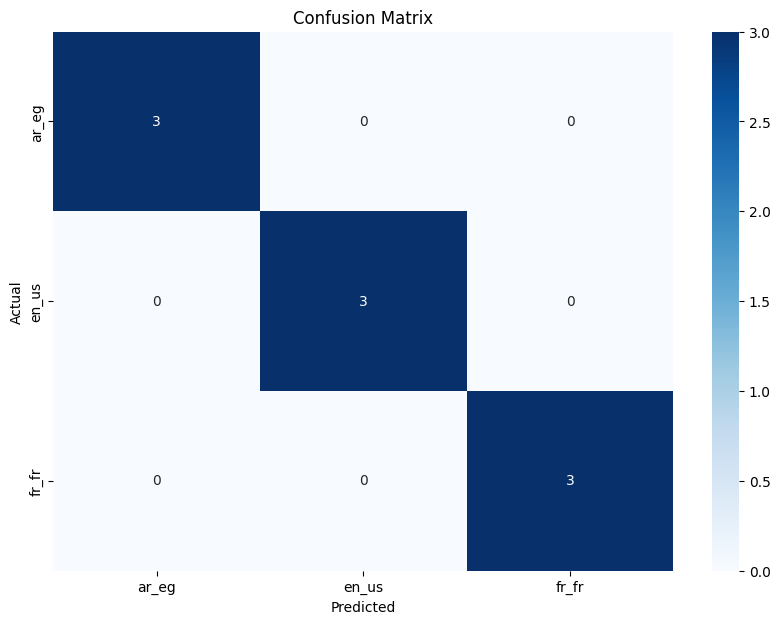

In [39]:
import os
import glob
import pandas as pd

def predict_directory(model, directory_path):
    # Create a list to store results
    results = []
    
    # Get all WAV files in the directory
    audio_files = glob.glob(os.path.join(directory_path, "*.wav"))
    
    # Process each file
    for audio_file in audio_files:
        try:
            # Get the filename
            filename = os.path.basename(audio_file)
            
            # Make prediction
            prediction = classifier(audio_file)
            prediction=(prediction[0]['label'])
            # Store result
            results.append({
                "file": filename,
                "prediction": prediction,
                "actual": os.path.basename(directory_path)  # Assuming directory name is the actual label
            })
            
            # Print progress
            print(f"Processed {filename}: Predicted {prediction}")
            
        except Exception as e:
            print(f"Error processing {audio_file}: {str(e)}")
    
    # Create a DataFrame for better visualization
    df = pd.DataFrame(results)
    
    # Calculate accuracy
    if len(df) > 0:
        df["correct"] = df["prediction"] == df["actual"]
        accuracy = df["correct"].mean() * 100
        print(f"\nAccuracy: {accuracy:.2f}%")
    
    return df

# Test Arabic samples
ar_results = predict_directory(loaded_model, "/kaggle/working/test_samples/ar_eg")
print("\nArabic Results:")
display(ar_results)

# Test English samples
en_results = predict_directory(loaded_model, "/kaggle/working/test_samples/en_us")
print("\nEnglish Results:")
display(en_results)

fr_results = predict_directory(loaded_model, "/kaggle/working/test_samples/fr_fr")
print("\nEnglish Results:")
display(en_results)

# Combined results
all_results = pd.concat([ar_results, en_results,fr_results], ignore_index=True)
print("\nAll Results:")
display(all_results)

# Confusion matrix
if len(all_results) > 0:
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Create confusion matrix
    cm = confusion_matrix(all_results["actual"], all_results["prediction"])
    
    # Create DataFrame for better visualization
    cm_df = pd.DataFrame(
        cm, 
        index=sorted(all_results["actual"].unique()), 
        columns=sorted(all_results["prediction"].unique())
        
    )
    
    # Plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

In [40]:
#done

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.
